In [1]:
import sys, time
sys.path.insert(0, "..")

import torch
import matplotlib.pyplot as plt
import numpy as np
from src.pinns import PINN
from src.utils.visualization import TrainingDataVisualizer as TDV

In [2]:
# reproducibility
torch.manual_seed(31)

In [3]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# 2) instantiate PINN
model = PINN(
    input_dim=2,
    hidden_dim=50,
    output_dim=1,
    num_hidden_layers=4,
    Nd=50, # number of boundary points
    Nf=1000, # number of collocation points
    device=device
)
model.to(device)
print("Using device:", next(model.parameters()).device)


Using device: cpu


In [6]:
# grab the data generated in PINN.__init__
X_train_Nu = model.X_train_Nu
U_train_Nu = model.U_train_Nu
X_train_Nf = model.X_train_Nf

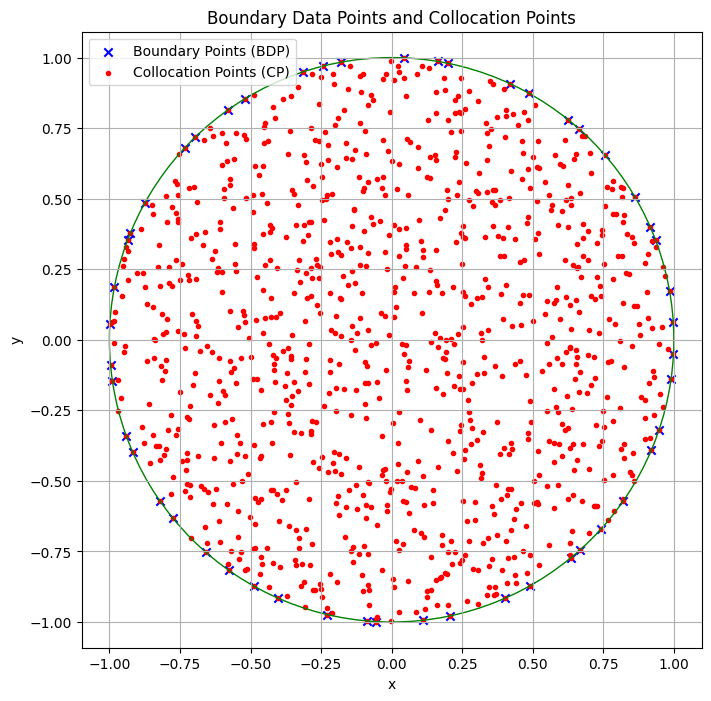

In [7]:
TDV.visualize_training_data(X_train_Nu, X_train_Nf)

In [9]:
pi = torch.tensor(np.pi, dtype=torch.float).to(device)

In [ ]:
epochs = 0
loss_values1 = 1
loss_values2 = 1
error = 1
loss_values = []

In [ ]:
start_time = time.time()
while loss_values2 > 1e-2:
    print("Training Loss ----- Test Loss")
    loss = model(p=2, bc_weight=10)
    loss_values.append(loss)

    if epochs == 0:
        loss_values1 = 1
        loss_values2 = loss_values[0]
        error = np.sqrt((loss_values2 - loss_values1)**2)
    else:
        loss_values1 = loss_values[epochs-1]
        loss_values2 = loss_values[epochs]
        error = np.sqrt((loss_values2 - loss_values1)**2)

    if epochs % 500 == 0:
        print(epochs,'-',loss)

In [ ]:
elapsed = time.time() - start_time
print('Training time: %.2f' % (elapsed))